# Redes Convolucionales Sep-Dic 2023

Raúl Guaidó 16-10486

CIFAR-10 es un conjunto de datos utilizado para el reconocimiento de objetos en imágenes. Al igual que MNIST, es uno de los conjuntos de datos más ampliamente utilizados por investigadores, ingenieros, practicantes y aficionados a la visión computarizada y machine learning.

CIFAR son las siglas del Canadian Institute for Advanced Research, donde Alex Krizhevsky, Vinod Nair y uno de los padres de la Inteligencia Artificial, Geoffrey Hinton, recopilaron un subconjunto del conjunto de datos 80 million tiny images.

Éstas son las características generales de CIFAR-10:

*   Se compone de 60.000 imágenes.
*   Cada imagen es 32x32x3, en espacio RGB.
*   Hay 50.000 imágenes de entrenamiento.
*   Hay 10.000 imágenes de prueba.
*   Hay 10 clases, donde cada una está representada por 6.000 imágenes.
*   Las clases son mutuamente excluyentes (es decir, una misma foto no puede pertenecer a más de una clase).

Estas son las 10 clases de CIFAR-10:

*   airplane (avión).
*   automobile (automóvil).
*   bird (ave).
*   cat (gato).
*   deer (venado).
*   dog (perro).
*   frog (rana).
*   horse (caballo).
*   ship (barco).
*   truck (camión).

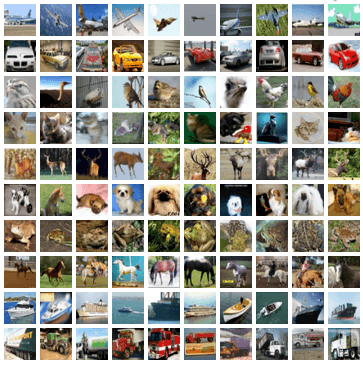




Para el modelo de la red convolucional se usara pytorch, esta libreria contiene todas las dependencias necesarias para el aprendizaje automatico, es ampliamente utilizado para aplicaciones de vision artificial y procesamiento de lenguaje natural, a parte nos permitira descargar el dataset y normalizarlo para poder usarlo como entrenamiento y test a la red.

Se utilizaran las librerias matplotlib y su extension matematica numpy para visualizar las imagenes y plotear lo deseado.

In [2]:
################################
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  f1_score, accuracy_score, confusion_matrix
from google.colab import drive
################################

Configuracion del DRive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/CNN Projects/Tarea2-Cifar10
%ls

[Errno 2] No such file or directory: '/content/drive/MyDrive/CNN Projects/Tarea2-Cifar10'
/content
drive/  sample_data/


Como se menciono, se usara el dataset CIFAR-10, el cual esta formado por 10 clases de imagenes diferentes y con una extencion de 60 mil imagenes.

Para descargarla se usa el metodo datasets de pytorch y para trasformar las imagenes a tensores y normalizarlos se usa el metodo transform igual de pytorch.


In [5]:
transform = transforms.Compose(
    [ToTensor(),
     transforms.Normalize(mean =[0.51, 0.46, 0.40], std =[0.22, 0.22, 0.22])])

batch_size = 5

train_set = torchvision.datasets.CIFAR10(root='./data_src', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data_src', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)

classes = ('Avion', 'Automovil', 'Ave', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camion')

100%|██████████| 170498071/170498071 [00:03<00:00, 49409868.79it/s]


Extracting ./data_src/cifar-10-python.tar.gz to ./data_src
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


A continuacion podemos visualizar 5 imagenes aleatorias del dataset de entrenamiento, las cuales estan identificadas con su clase.

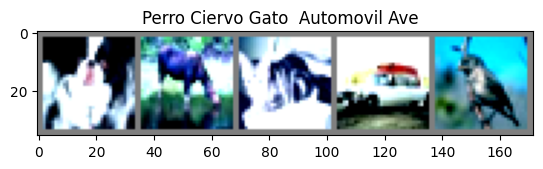

In [6]:
def imagenshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imagenshow(torchvision.utils.make_grid(images))


# Definicion del Modelo de la CNN

Para esta se uso pytorch, se diseño un modelo de dos capas convolucionales.

La primera capa (Conv1), tiene 3 canales de entrada y produce 20 canales de salida, para realizar la convolucion usa un filtro de 5x5.

La segunda capa (Conv2), tiene 20 canales de entrada, conectadas de la capa anterior, y produce 40 canales de salida. Usa el mismo filtro de la capa anterior para realizar las convoluciones.

Capa de pooling, seguida de cada capa convolucional se realiza un pooling con la intencion de reducir el tamaño espacial de la imagen.

Seguidamente de la capa de pooling se usa flatten para convertir la salida en un tensor unidimencional y finalmente aplicarle la funcion de activacion Scaled Exponential Linear Unit.

Como funicon de perdida se utiliza CrossEntropyLoss y como optimizador el Stocastic Gradient Descense, con una tasa de aprendizaje de 0.002 y un momentum de 0.85.

In [7]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 40, 5)
        self.fc1 = nn.Linear(40* 5* 5, 420)
        self.fc2 = nn.Linear(420, 180)
        self.fc3 = nn.Linear(180, 80)
        self.fc4 = nn.Linear(80, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.fc4(x)
        return x


CNN1 = CNN1()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN1.parameters(), lr=0.002, momentum=0.85)

# Entrenamiento del Modelo de la CNN

Se realiza la iteracion sobre el train_loader, cada 2000 iteraciones se muestra la funcion de perdida, al inicio se reinician los gradientes del optimizador y se van actualizando estos valores.

Este proceso se realiza durante 10 decadas, y se va actualizando la perdida para cada decada.

In [8]:
array_loss= []


for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = CNN1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if i % 2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_loader):.3f}')

    array_loss.append((running_loss)/len(train_loader))

print('Finished Training')

[1, 10000] loss: 1.467
[2, 10000] loss: 1.091
[3, 10000] loss: 0.950
[4, 10000] loss: 0.850
[5, 10000] loss: 0.761
[6, 10000] loss: 0.682
[7, 10000] loss: 0.616
[8, 10000] loss: 0.552
[9, 10000] loss: 0.498
[10, 10000] loss: 0.456
Finished Training


# Carga del modelo entrenado en la carpeta 'Training_Model.pt'



In [9]:
PATH = './Training_Model.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': CNN1.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            }, PATH)

# Calculo de la precision del modelo ya entrenado

A continuacion se muestra la precision de la red a nivel general

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = CNN1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 71 %


Seguidamente se muestra el calculo de la preciocion por clases, esto nos permite ver que la red tiene un alto porcentaje correcto de prediccion.

In [28]:
class_name = ['Avion', 'Automovil', 'Ave', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camion']
correct_predictions = [0] * len(class_name)
total_images = [0] * len(class_name)

for data in test_loader:
    images, labels = data
    outputs = CNN1(images)
    _, predicted = torch.max(outputs.data, 1)
    for i in range(len(labels)):
        label = labels[i]
        prediction = predicted[i]
        if label == prediction:
          correct_predictions[label] += 1
        total_images[label] += 1


class_accuracy = [100*correct_predictions[i] / total_images[i] for i in range(len(class_name))]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


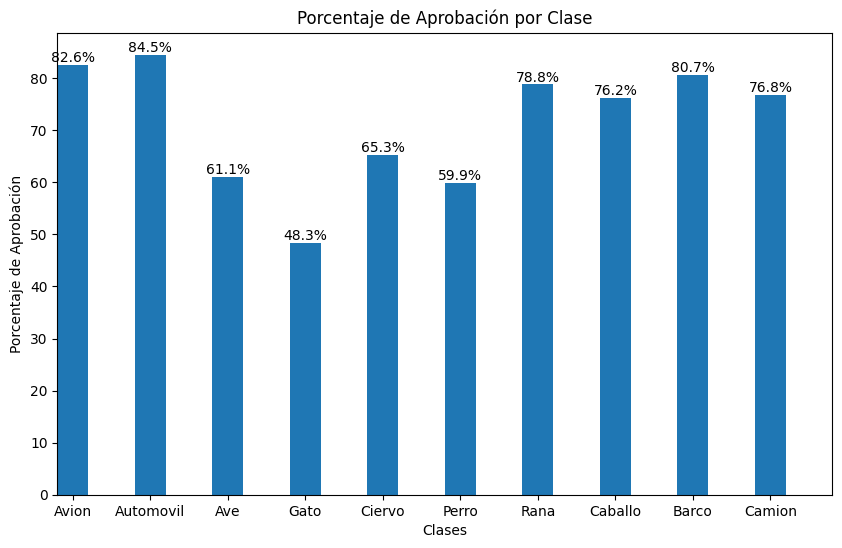

In [29]:
plt.figure(figsize=(10, 6))
bar_width = 0.4
bar_spacing = 0.2
plt.bar(np.arange(len(class_name)), class_accuracy, width = bar_width)
plt.xticks(np.arange(len(class_name)), class_name)
plt.xlabel('Clases')
plt.ylabel('Porcentaje de Aprobación')
plt.title('Porcentaje de Aprobación por Clase')
for i, v in enumerate(class_accuracy):
    plt.text(i, v, str(v) + '%', ha='center', va='bottom')

plt.xlim(-bar_spacing, len(class_name) - bar_spacing)
plt.show()

# Mapa de Calor

Para la primera capa convolucional el mapa de calor nos permite visualizar cuales son las regiones de activacion mas importantes, observando que es bastante aleatorio como es de esperarse.

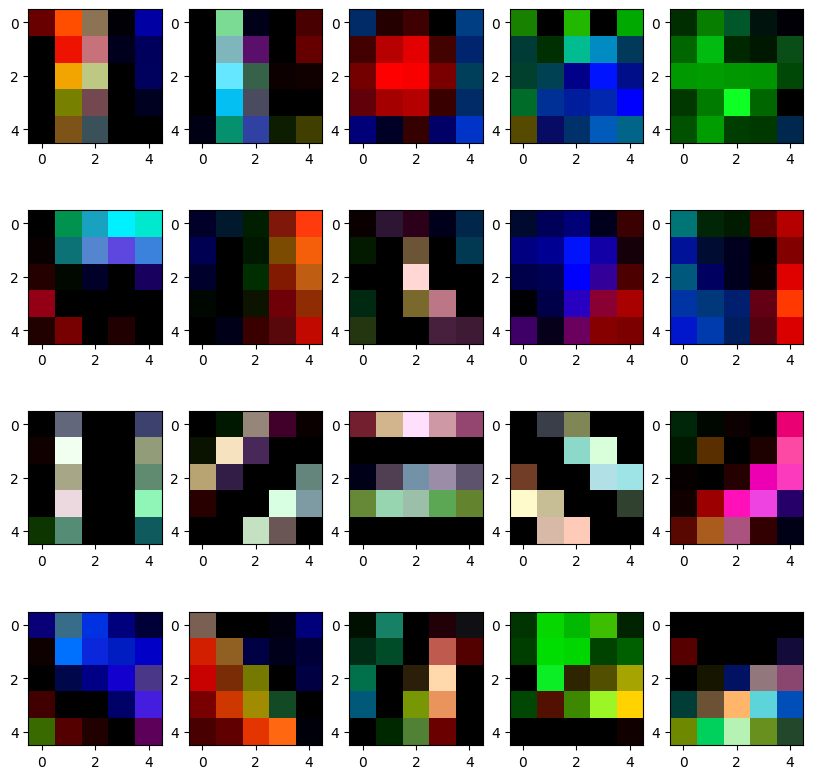

In [30]:
weight1 = []

for x in CNN1.state_dict()['conv1.weight']:
      w1 = np.transpose(x)
      w1 = w1/w1.max()
      w1 = np.clip(w1, 0, 1)
      weight1.append(w1)

figure, axes = plt.subplots(nrows=4, ncols=5, figsize =(10,10))

for a, b in zip(axes.ravel(), range(20)):
  nimage = np.random.randint(len(weight1))
  a.imshow(weight1[b])

Para la segunda capa se observan zonas mas intensas lo que nos muestra cuales son los pixeles que mas toma en consideracion la red para tomar la decision de la prediccion en funcion a la imagen que se esta prediciendo.

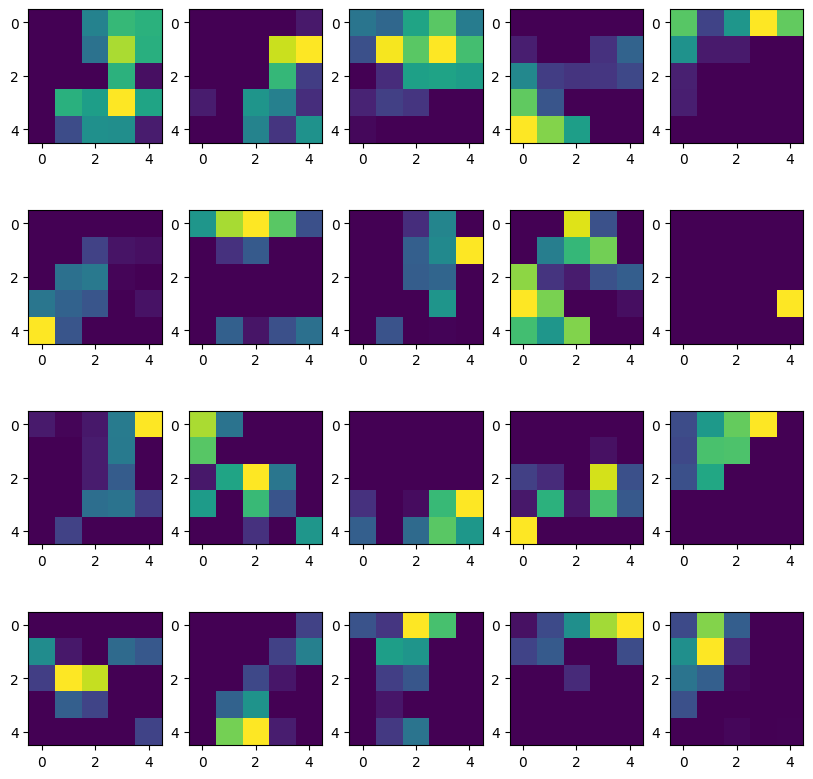

In [31]:
weight2 = []
for x in CNN1.state_dict()['conv2.weight']:
  for w in x:
      w2 = w
      w2 = w2/w2.max()
      w2 = np.clip(w2, 0, 1)
      weight2.append(w2)

figure, axes = plt.subplots(nrows=4, ncols=5, figsize =(10,10))

for a, b in zip(axes.ravel(), range(30)):
  nimage = np.random.randint(len(weight2))
  a.imshow(weight2[b])

# Conclusiones

Al entrenar el modelo, se logro una mejora de este de un 50% inicialmente a un 71%, esto al realizar cambios en la arquitectura de la red.
Al aumentar el numero de canales internos de la red y cambiar de ReLU a SeLU, nos permitio realizar una mejora considerable al modelo.

Se puede observar que la precision por clases es bastante buena para la mayoria de estas. Esto podria mejorarse al introducir mas capas convolucionales a la red.

Los cambios realizados tuvieron como consecuencia un aumento considerable en el tiempo de entrenamiento, de 5 a 10 min aproximadamente a 30 min o mas, esto debido al incremento de los canales.